# VisualNLP - Text regions detection with endpoints

This demo shows improved abilities of VisualNLP to detect text regions of different kinds. Correct detection of regions belonging to text tokens is important for different task like de-id and similar.

Recently VisualNLP went beyond usual ways of calling AI models inference. Previous ways are limited by available hardware and its cost. Endpoints are one of new ways that help to speed up and optimize inference cost. Our models supports following options of endpoints:

*   Databricks Model Serving
*   Amazon SageMaker

Each serving options has a number of available models. Below are a sample of calling them.



## Setup

At first we set up working environment.

In [ ]:
!wget https://www.dropbox.com/scl/fi/6zromctsqiaxf7khk2ews/samples_text_detection.tar.xz?rlkey=uuvx3uh7amvqa66ue9i54x7xs&st=mn5ep3tq&dl=0
!mv samples_text_detection.tar.xz?rlkey=uuvx3uh7amvqa66ue9i54x7xs samples_text_detection.tar.xz
!tar -xf samples_text_detection.tar.xz

In [ ]:
!wget https://www.dropbox.com/scl/fi/73ilg8ft3t2gge6xcc6qe/spark-ocr-assembly-6.1.0.jar?rlkey=rl5w002jomivf4wq7pckr70dt&st=u8x66tll&dl=0
!wget https://www.dropbox.com/scl/fi/08euhl4nfo1p45qj8ckup/spark_ocr-6.0.0-py3-none-any.whl?rlkey=weuh33y9suzxe6zeyw9gqcyty&st=x76s0gd6&dl=0
!mv spark-ocr-assembly-6.1.0.jar\?rlkey\=rl5w002jomivf4wq7pckr70dt spark-ocr-assembly-6.0.1rc8.jar
!mv spark_ocr-6.0.0-py3-none-any.whl\?rlkey\=weuh33y9suzxe6zeyw9gqcyty spark_ocr-6.0.0-py3-none-any.whl

In [ ]:
%pip install --no-deps spark_ocr-6.0.0-py3-none-any.whl
%pip install spark-nlp pyspark==3.5.0

## Initialization

Next step is to initialize Spark session and to load input data (images) to dataframe. Here we use a couple of samples - one for printed text and another one is handwritten text.

In [4]:
from pyspark.sql import SparkSession
from sparkocr import start
from pyspark import SparkConf
import sys
import os
import json

os.environ['SPARK_OCR_LICENSE'] = ""

conf = SparkConf() \
.set("spark.extraListeners", "com.johnsnowlabs.license.LicenseLifeCycleManager") \
.set("spark.sql.legacy.allowUntypedScalaUDF", "true")

spark = start(jar_path="/content", extra_conf=conf)
spark

Spark version: 3.5.0
Spark NLP version: 6.3.1
Spark OCR version: 6.0.1rc8




    Image #0:
    Origin: file:/content/samples_text_detection/image_raw.jpg
    Resolution: 0 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: 10
    Number of channels: 1


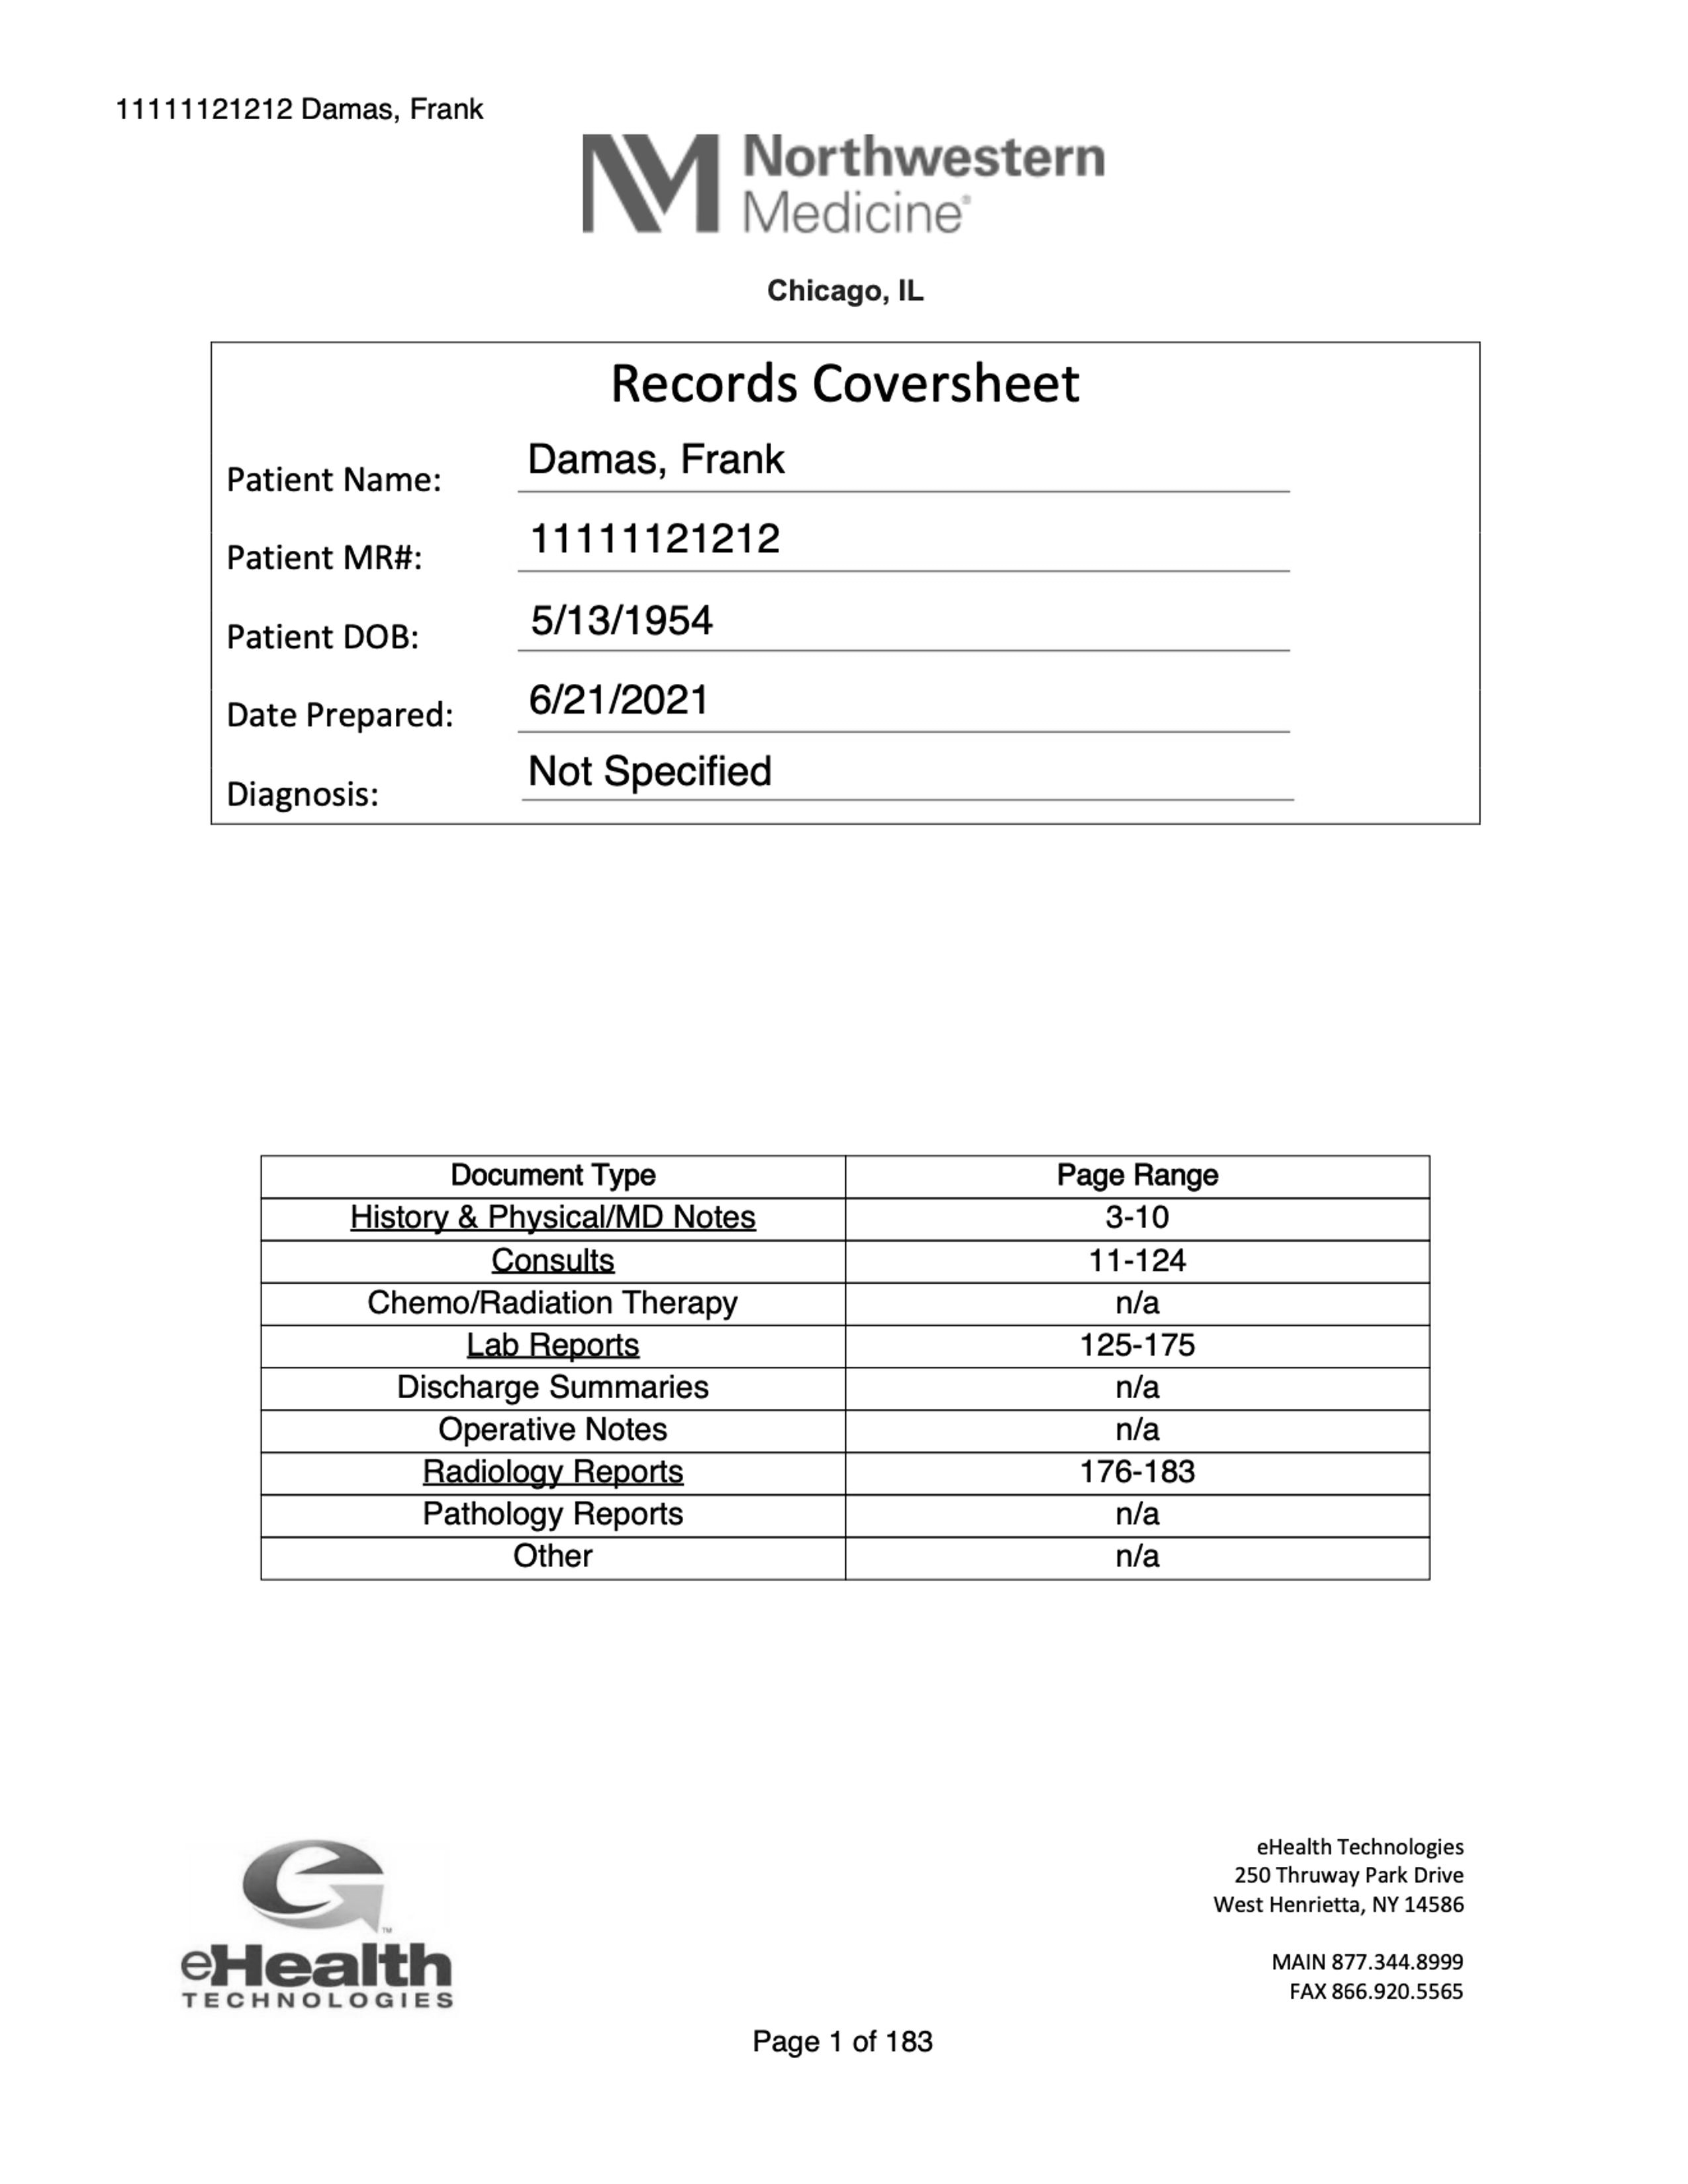


    Image #1:
    Origin: file:/content/samples_text_detection/handwritten.png
    Resolution: 0 dpi
    Width: 2774 px
    Height: 3455 px
    Mode: 10
    Number of channels: 1


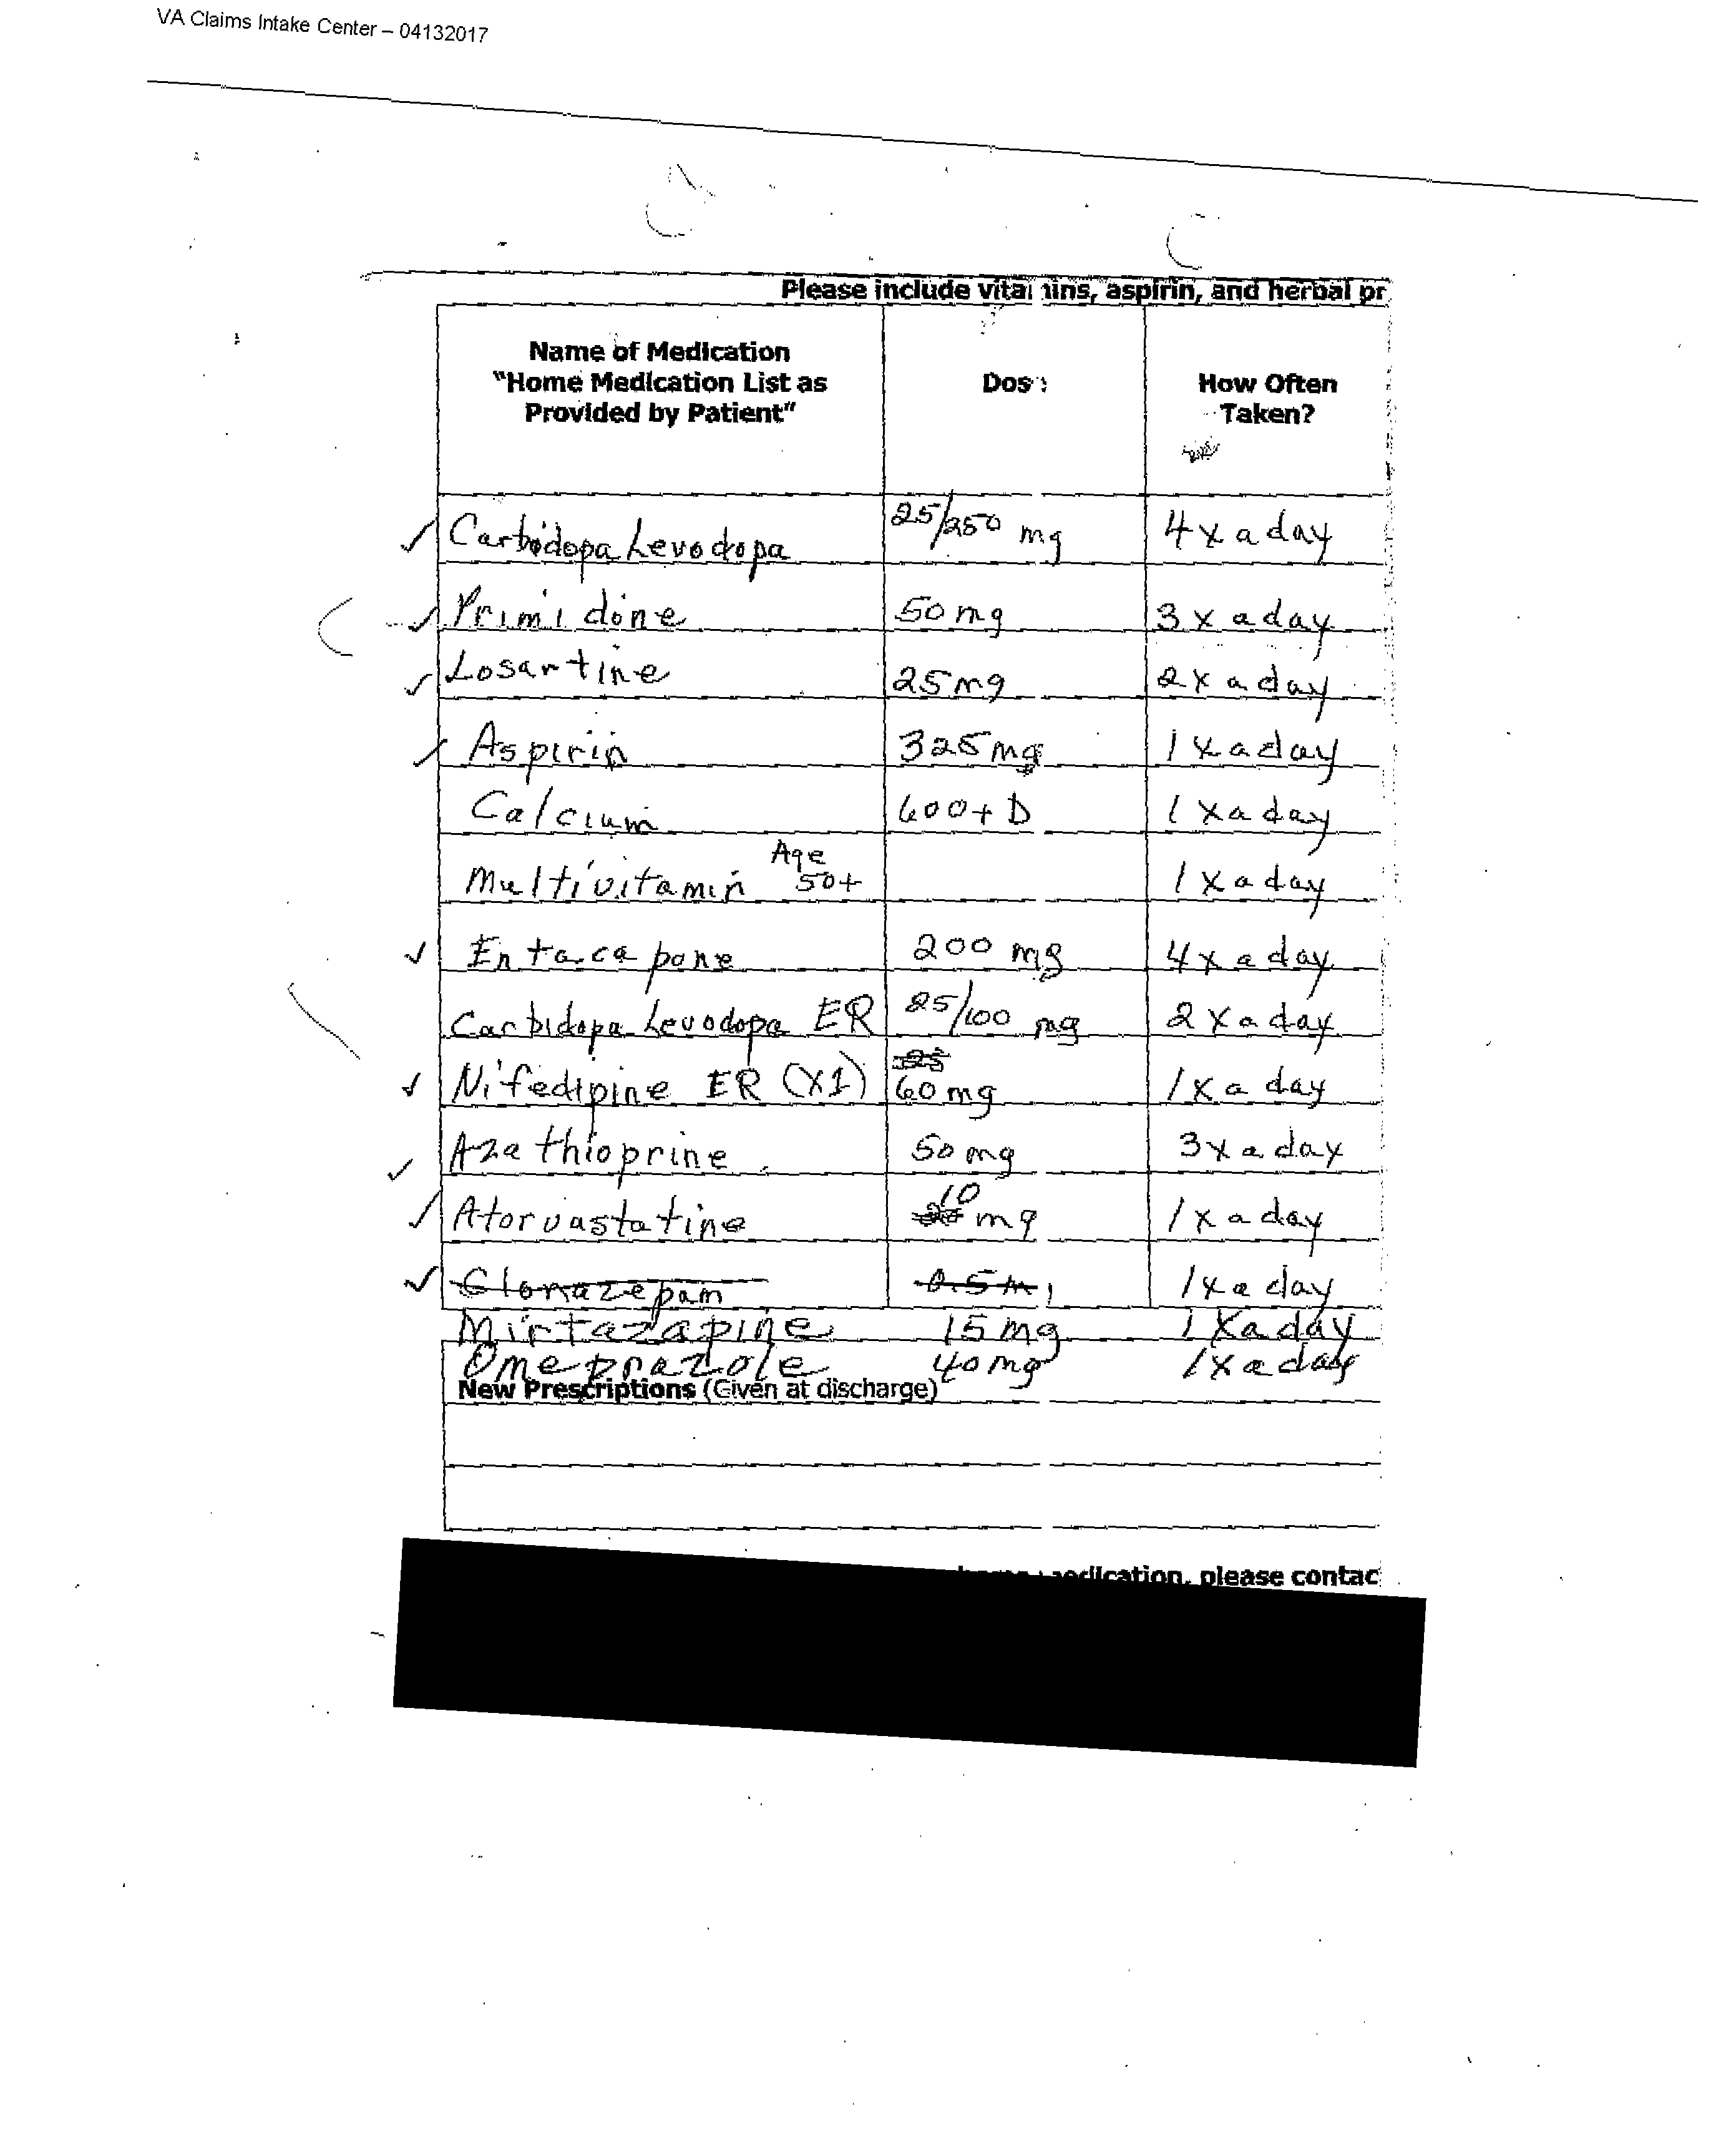

In [5]:
from sparkocr.transformers import *
from sparkocr.enums import *
from sparkocr.utils import display_images
from pyspark.ml import PipelineModel

df = spark.read.format("binaryFile").load("/content/samples_text_detection/*").cache()
display_images(BinaryToImage().transform(df))

## Inference and visualization

We use 2 pipelines to process data:


1.   Pipeline 1 calls model to get recognized texts and coordinates in HOCR format
2.   Pipeline 2 here is for visualization purpose. It places bounding boxes over recognized texts. At top of bboxes you may see recognized text.



In [6]:
from pyspark.ml import Transformer
from pyspark.ml.param.shared import HasInputCol, HasOutputCol
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.sql.functions import udf

binary_to_image = BinaryToImage() \
    .setImageType(ImageType.TYPE_3BYTE_BGR) \
    .setKeepInput(True)

# Detect labels to deidentified in the input document
text_detector = ImageToTextWeb() \
    .setInputCol("content") \
    .setOutputCol("text") \
    .setServerAddress("3.142.150.93") \
    .setServerPath("/invocations") \
    .setServerPort(8888) \
    .setOutputFormat(OcrOutputFormat.HOCR)

# OCR pipeline
pipeline1 = PipelineModel(stages=[
    binary_to_image,
    text_detector,
])

res1 = pipeline1.transform(df).cache()
res1.select("text").show()

+--------------------+
|                text|
+--------------------+
|<div title="bbox ...|
|<div title="bbox ...|
+--------------------+



In [7]:
tokenizer = HocrTokenizer() \
    .setInputCol("text") \
    .setOutputCol("token")

draw_annotations = ImageDrawAnnotations() \
    .setInputCol("image") \
    .setInputChunksCol("token") \
    .setOutputCol("image_with_annotations") \
    .setFilledRect(False) \
    .setFontSize(40)

pipeline2 = PipelineModel(stages=[
    tokenizer,
    draw_annotations
])

# Bboxes visualisation
res = pipeline2.transform(res1).cache()
res.show()

+--------------------+--------------------+-------------------+------+--------------------+-------+--------------------+--------------------+----------------------+---------+
|               image|                path|   modificationTime|length|             content|pagenum|                text|               token|image_with_annotations|exception|
+--------------------+--------------------+-------------------+------+--------------------+-------+--------------------+--------------------+----------------------+---------+
|{file:/content/sa...|file:/content/sam...|2026-01-15 13:25:20|355762|[FF D8 FF E0 00 1...|      0|<div title="bbox ...|[{token, 0, 0, <,...|  {file:/content/sa...|     NULL|
|{file:/content/sa...|file:/content/sam...|2026-01-15 13:25:17|124151|[89 50 4E 47 0D 0...|      0|<div title="bbox ...|[{token, 0, 0, <,...|  {file:/content/sa...|     NULL|
+--------------------+--------------------+-------------------+------+--------------------+-------+--------------------+-----


    Image #0:
    Origin: file:/content/samples_text_detection/image_raw.jpg
    Resolution: 0 dpi
    Width: 2550 px
    Height: 3299 px
    Mode: 5
    Number of channels: 3


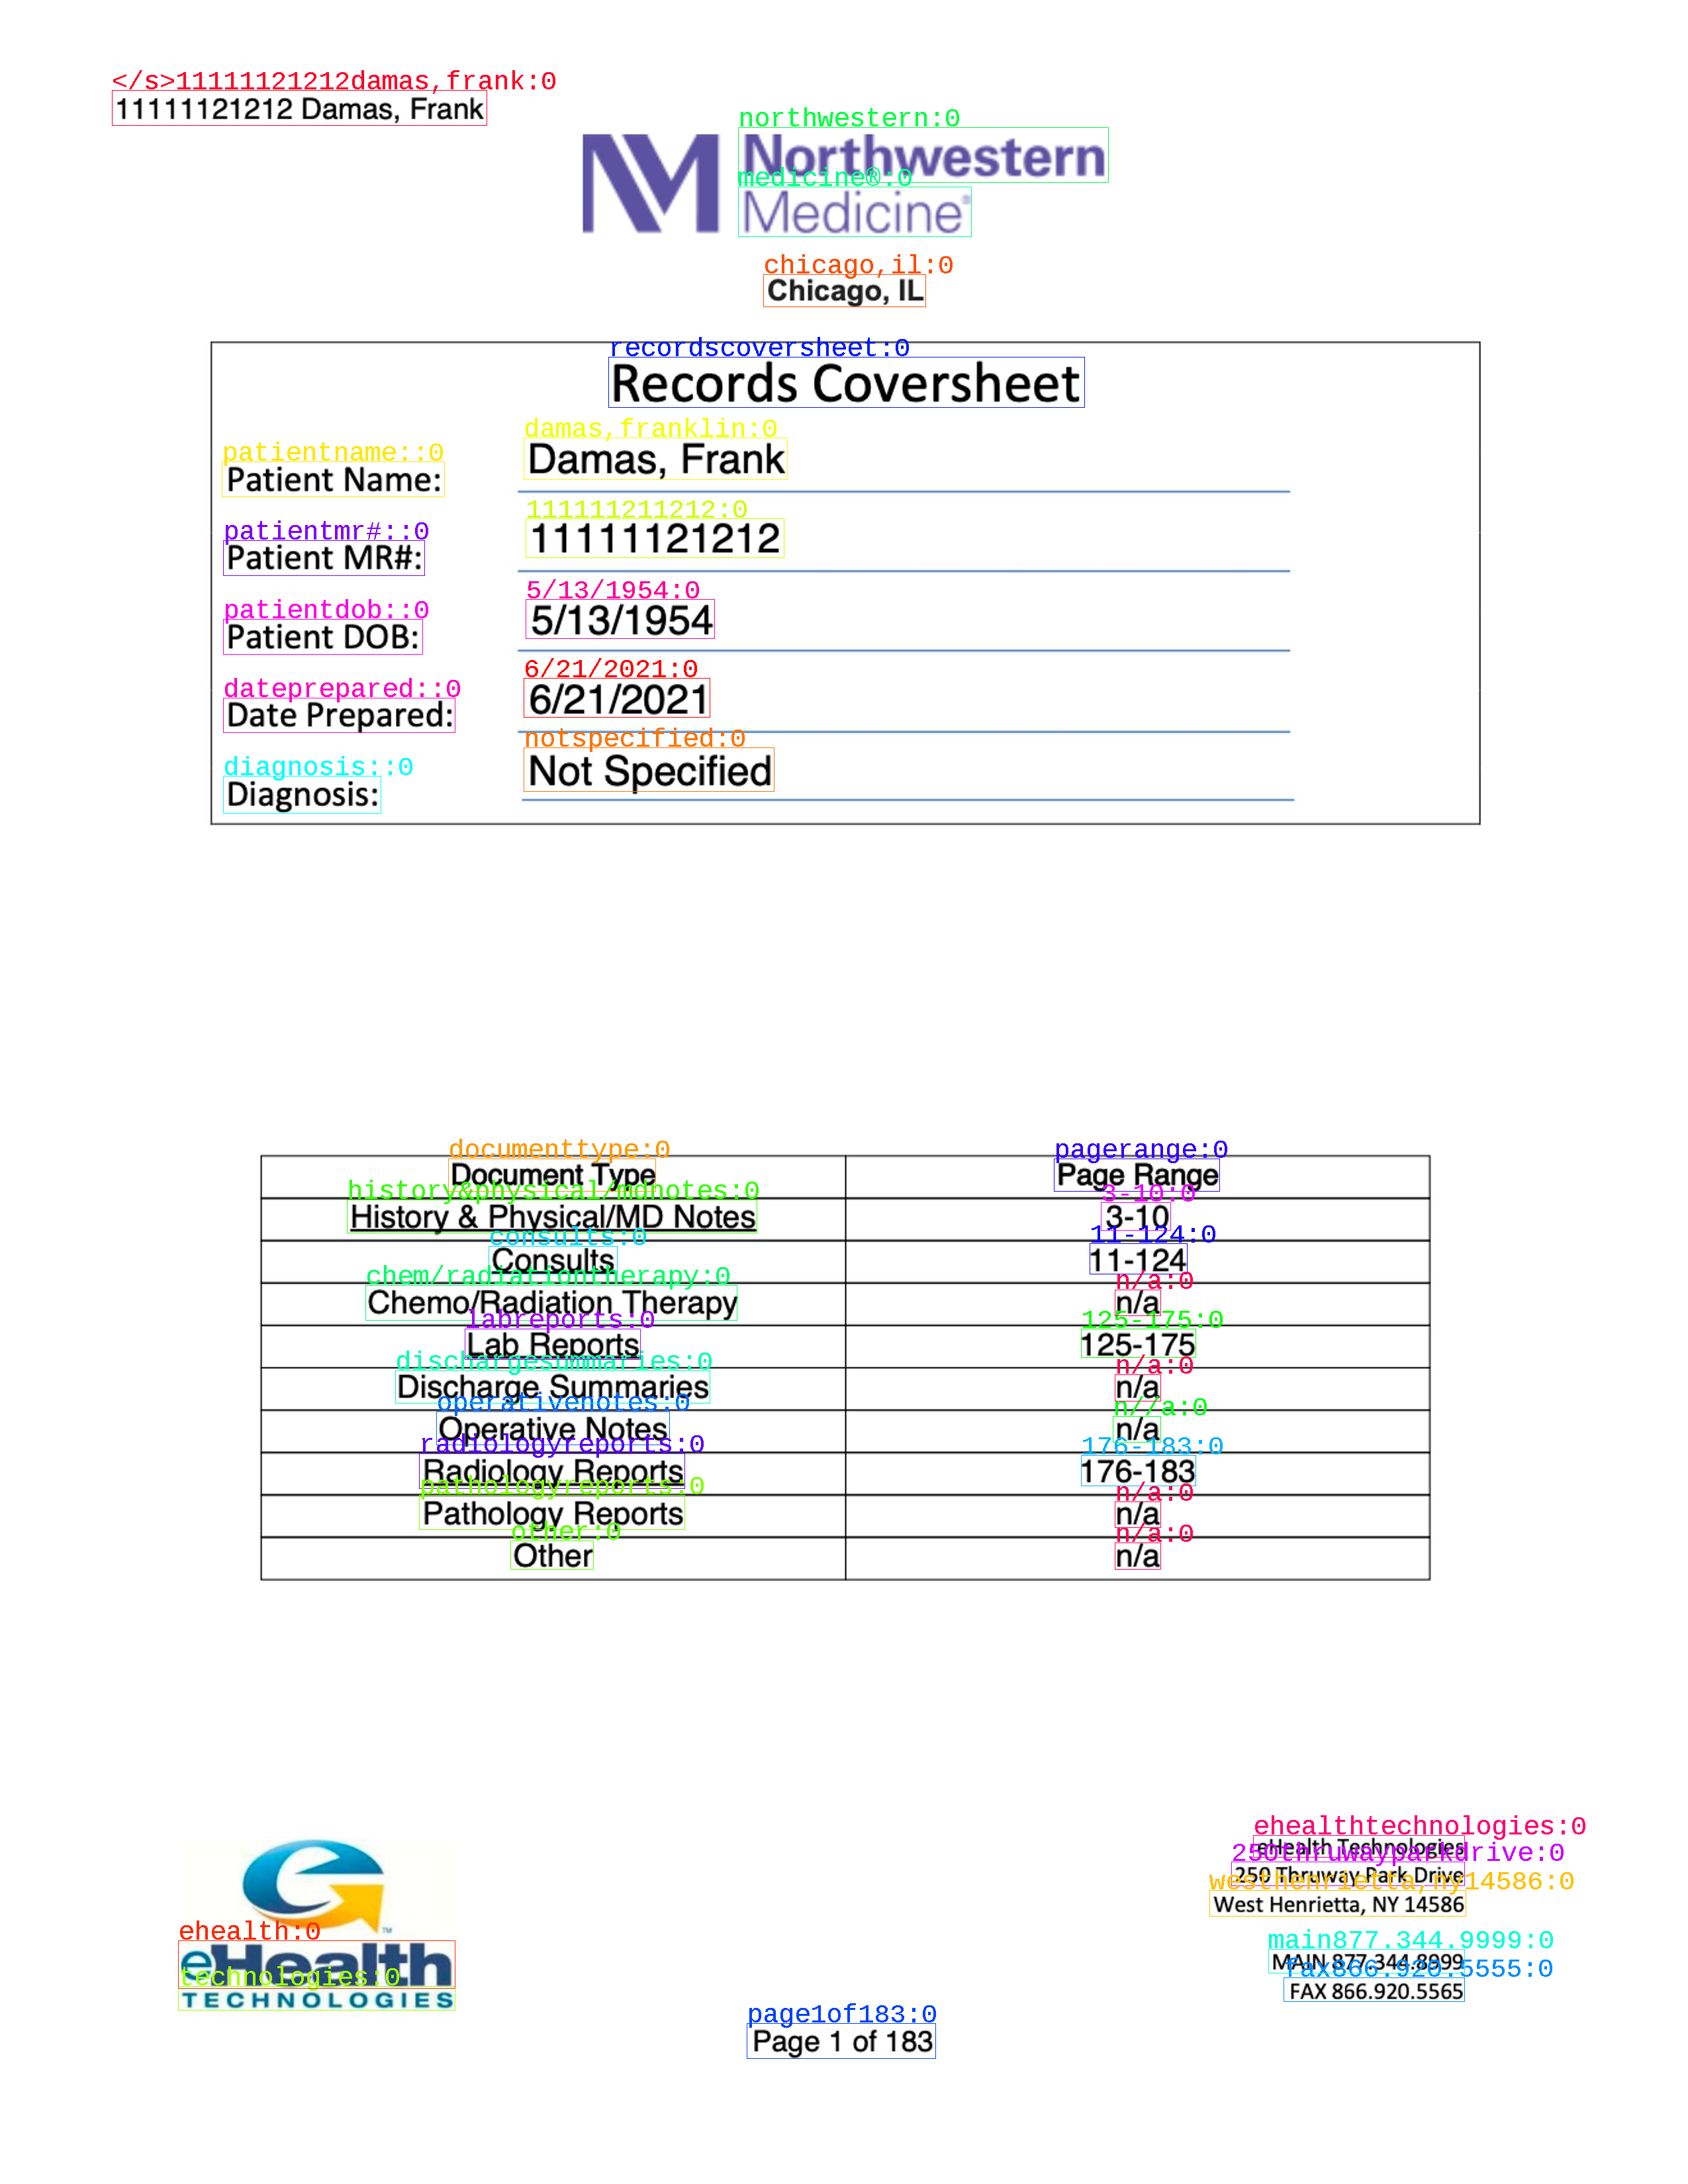


    Image #1:
    Origin: file:/content/samples_text_detection/handwritten.png
    Resolution: 0 dpi
    Width: 2774 px
    Height: 3455 px
    Mode: 5
    Number of channels: 3


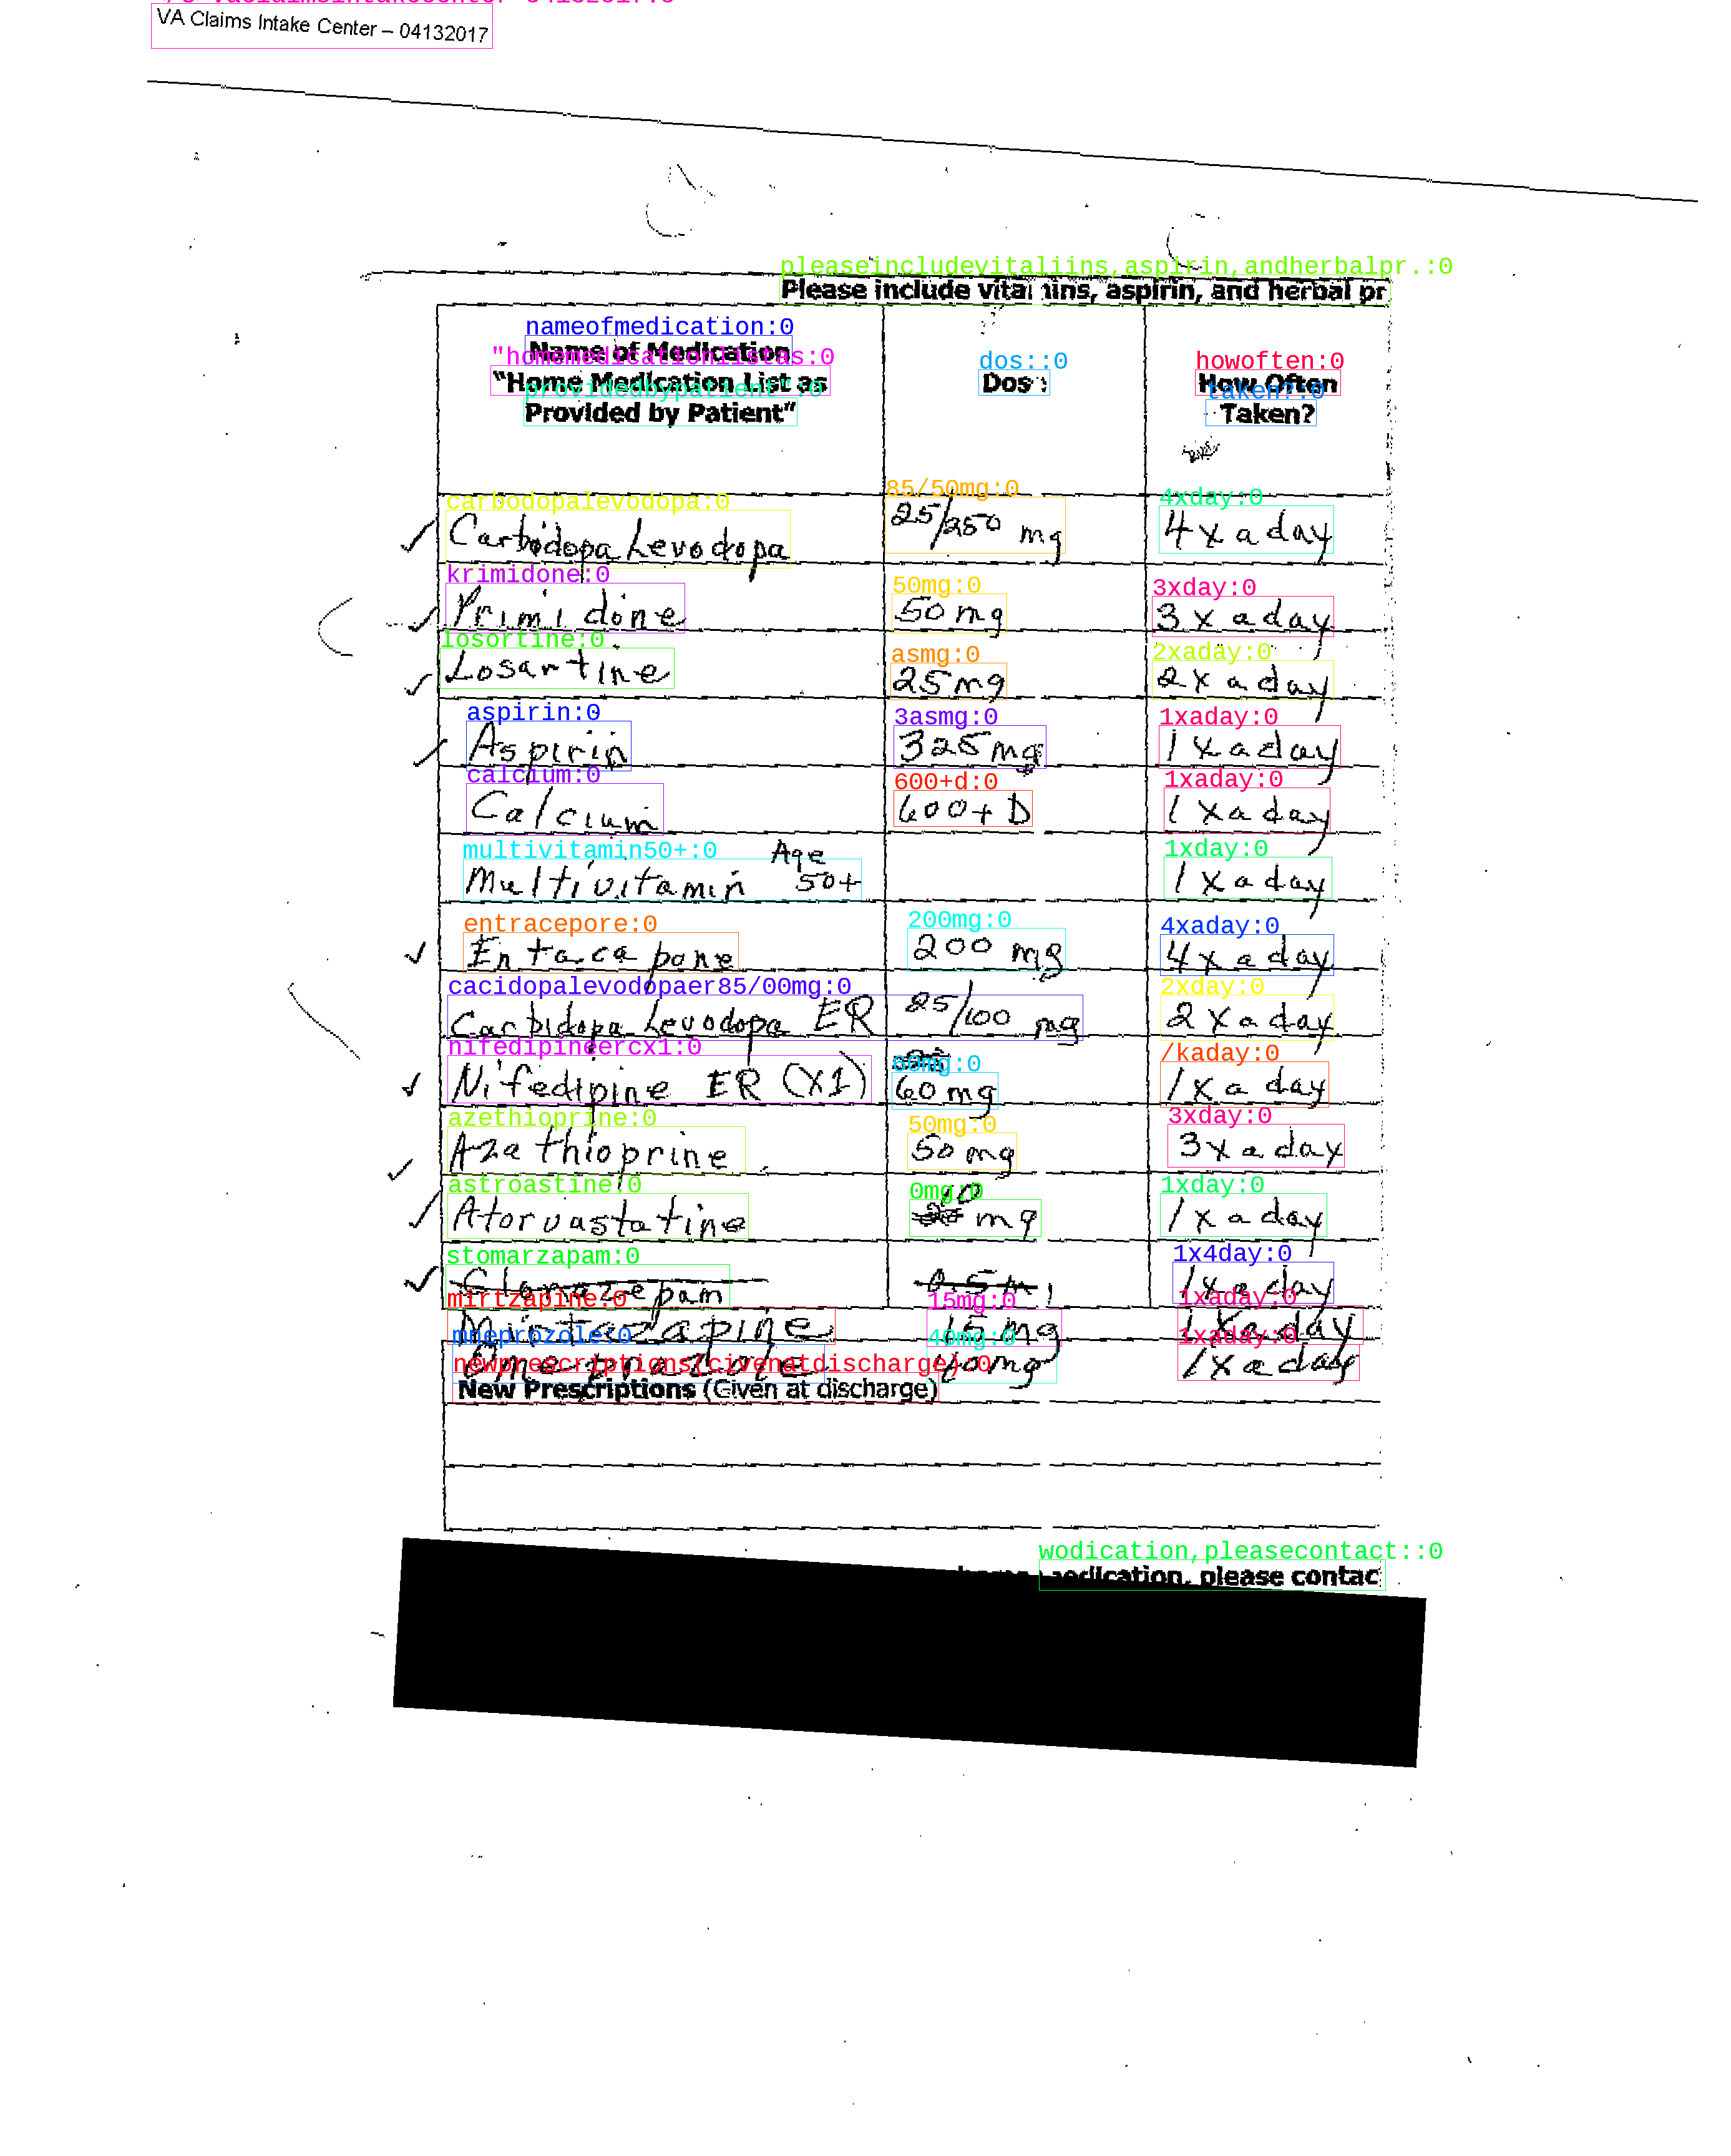

In [8]:
display_images(res, "image_with_annotations", width=1000)

From images above you may see that model is pretty accurate in terms of both text recognition and text detection.

Calling of models on Databricks Model Serving and Amazon SageMaker is done in the same way from pipeline side. Just params settings may be different. Contact us for more details.